# EOSDIS Zarr Store: Spatial & Variable Subsetting without Services

## Goal

Produce a library that would let the Zarr Python library read EOSDIS cloud holdings efficiently, without requiring any modifications to our archive.  This has the potential to expand use to new communities and tools, allow more efficient access both in place and outside of the cloud, and therefore save money for the archive as well as time for users.

## Background

This is a demo of a data store I've been working on, building off of the work of a few others.  Adapting the Zarr library (which is meant to read cloud-optimized data stores) read NetCDF4 / HDF 5 files was discussed as a possibility at Summer ESIP last year.  Rich Signell from USGS worked with HDF Group to get [a prototype](https://medium.com/pangeo/cloud-performant-reading-of-netcdf4-hdf5-data-using-the-zarr-library-1a95c5c92314).  The resulting code showed no performance degradation over an equivalent native Zarr store.  This adaptation requies an up-front generation of metadata containing data attributes and byte offsets to allow efficient reads.

## What I did

I recognized that the DMR++ files OPeNDAP / GHRC have started generating on ingest in PI 20.1 contain nearly equivalent information to that required by the Zarr library.  Hearing that small chunk sizes (chunks are a region of data that can / must be read all at once) caused issues for some NetCDF files and required re-chunking (i.e. altering the original data file), I further looked at mitigating that issue to avoid having to re-host data.  In picking through the Zarr code, I came across a for loop that, if changed, would allow a set of optimizations that would greatly improve performance.  I advocated for this in the Zarr tracker and what we need is now being planned.
![png](summary.png)

In terms of actual code, I produced a Python library, eosdis-zarr-store that:

1. Implements the Zarr storage API in a natural and familiar way to Zarr developers
2. Sets up HTTP access to allow EDL credential handshaking and, importantly, caching of redirect URLs
3. Adapts our underlying data files and DMR++ files generated on ingest to a Zarr-compatible API
4. Implements optimizations using the API worked out with the Zarr community to make fewer total data reads and do them in parallel where possible

The remainder of this notebook contains results and conclusions.

## How to use it

In the eosdis-zarr-store directory run `pip install -e .`.  Obtain or stage an HDF5 (NetCDF4) file along with a DMR++ file with identical URL + ".dmrpp", you can run "mkdmrpp" in this folder to produce DMR++ files.  Then:

```python
from eosdis_zarr_store import Store
import zarr

f = zarr.open(Store(data_file_url))
# Manipulate f as any Zarr store (see examples below)
```

The URLs in this notebook will not be available for general use, since one example produces 500 MB of egress for benchmarking.

## Helpers and Constants (You can skip this)

In [1]:
# Helpers to draw stuff, generate URLs, and translate bounding boxes to array indices, 
# wholly ignoring all the helpful attributes present in the HDF and Zarr metadata
# Please don't judge me on this mess.  It's not called "Clean code fest"

from matplotlib import pyplot as plt
from matplotlib import colors
from ipypb import track
import numpy as np

def show(data, transpose=True):
    plt.rcParams["figure.figsize"] = [16, 8]
    if transpose:
        data = np.transpose(data)
    plt.imshow(data[::-1,:], norm=colors.Normalize(0, 150), cmap='Blues')

def get_aoi(bbox, scale, x0=180, y0=90):
    aoi = (0, 
           slice(scale * int(bbox[1] + x0), scale * int(bbox[3] + x0) + 1), 
           slice(scale * int(bbox[0] +  y0), scale * int(bbox[2] + y0) + 1))
    shape = [d.stop - d.start for d in aoi[1:]]
    return aoi, shape

url_root = 'https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/demo/zarr-store/'
# GPM HHR URLs
filename_template = '3B-HHR.MS.MRG.3IMERG.20051022-S%02d%02d00-E%02d%02d59.%04d.V06B.HDF5'
data_urls = [ url_root + filename_template % (h, m, h, m + 29, h * 60 + m) for h in range(0, 24) for m in range(0, 60, 30) ]

bbox = [10, -100, 47.5, -45]

# Basic file info (also readable from metadata)
GPM_NODATA = -9999.9
gpm_aoi, gpm_shape = get_aoi(bbox, 10)
RSS_NODATA = 251
RSS_SCALE_FACTOR = 0.5 # In-file scale factor is 0.1.  This increases it solely for the purpose of making it show up in pics
rss_aoi, rss_shape = get_aoi(bbox, 4, 360)
rss_aoi = (0, rss_aoi[2], rss_aoi[1])


## Problem 1: Atmospheric water vapor off the East Coast on Patrick's wedding day

It rained a little that day in DC and hurricanes were threatening our honeymoon in the Carribbean.

We have a bounding box defined above.  Use data distributed by GHRC derived from the SSMIS sensor of the F16 DMSP satellite to build a picture.

### Without Partial Access

Download 2.6 MB file and subset it

CPU times: user 199 ms, sys: 19.6 ms, total: 218 ms
Wall time: 3.49 s


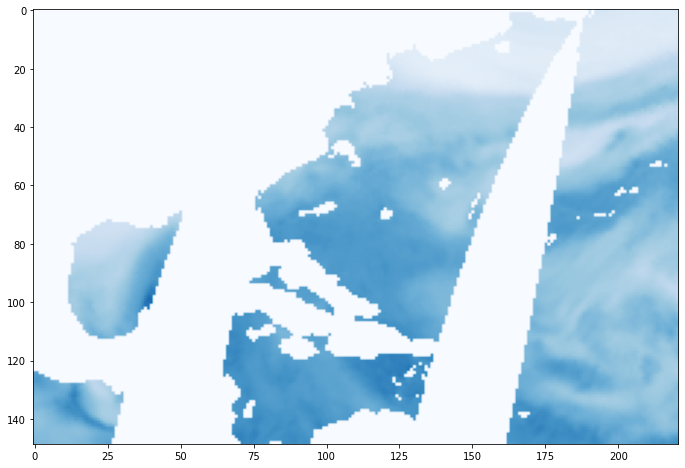

In [2]:
%%time
from h5py import File as H5File
import requests
from io import BytesIO

response = requests.get(url_root + 'f16_ssmis_20051022v7.nc')
with H5File(BytesIO(response.content), 'r') as f:
    aoi_data = f['atmosphere_water_vapor_content'][rss_aoi]
    show(np.where(aoi_data < RSS_NODATA, aoi_data * RSS_SCALE_FACTOR, 0), transpose=False)


### Partial Access Step 1 - Make our data readable in Zarr for partial access

Mimick a Zarr store by reading OPeNDAP's DMR++ files and returning their metadata in a Zarr interface.  DMR++ files are planned to be generated on ingest

Downloads 200 KB of data from the 2.6 MB file with conventional Zarr storage implementation.

Result: 12 data requests, each of which goes through internet services, pre-signs a URL, and redirects to the data range.  All sequentially.  Slow.

Starting new range due to gap of 74000 bytes
Starting new range due to gap of 41722 bytes
Merged 12 requests into 3
Reading https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/demo/zarr-store/f16_ssmis_20051022v7.nc [1455912:1488808] (32896 bytes)
Reading https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/demo/zarr-store/f16_ssmis_20051022v7.nc [1562808:1593902] (31094 bytes)
Reading https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/demo/zarr-store/f16_ssmis_20051022v7.nc [1635624:1654949] (19325 bytes)
CPU times: user 178 ms, sys: 13.6 ms, total: 192 ms
Wall time: 5.8 s


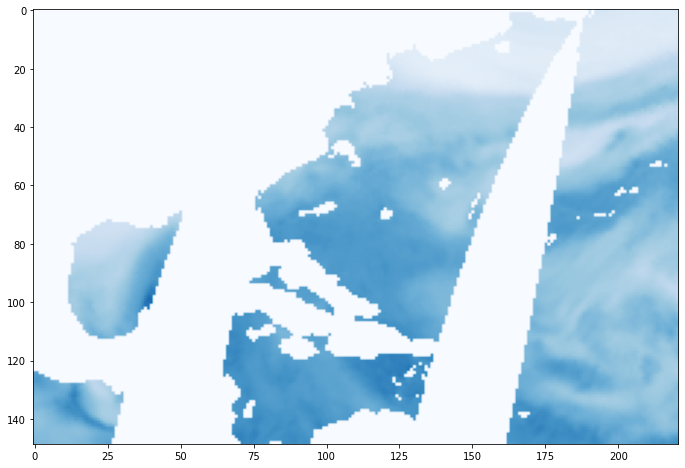

In [3]:
%%time
from aszarr import Store
import zarr

f = zarr.open(Store(url_root + 'f16_ssmis_20051022v7.nc'))
aoi_data = f['atmosphere_water_vapor_content'][rss_aoi]
show(np.where(aoi_data < RSS_NODATA, aoi_data * RSS_SCALE_FACTOR, 0), transpose=False)

### Partial Access Step 2 - Make Zarr reads fast

Downloads 200 KB of data from the 2.6 MB file with Zarr optimizations: 
1. (Working with Zarr community) Implement "getitems" concept, allowing storage to know all of the chunks that will be accessed up front
2. Combine nearby range requests into single HTTP requests before sending them, allowing fewer requests.
3. Cache presigned URLs returned by the archive for a short time, as directed by caching headers (TEA has a ticket to add these), allowing reuse and avoiding many round-trips and redirects
4. Run the first data range request serially to get the presigned URL.  Run subsequent requests in parallel.

Result: 3 data requests, one of which goes through internet services, pre-signs a URL, and redirects to the data range.  The following two reuse the signed URL and fetch in parallel.  Faster!

When more than a couple of chunks are involved, this is expected to be faster than the native Zarr S3 format is capable of, and the more chunks involved in a read the more it improves.

Starting new range due to gap of 74000 bytes
Starting new range due to gap of 41722 bytes
Merged 12 requests into 3
Reading https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/demo/zarr-store/f16_ssmis_20051022v7.nc [1455912:1488808] (32896 bytes)
Reading https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/demo/zarr-store/f16_ssmis_20051022v7.nc [1562808:1593902] (31094 bytes)
Reading https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/demo/zarr-store/f16_ssmis_20051022v7.nc [1635624:1654949] (19325 bytes)
CPU times: user 50.5 ms, sys: 8.5 ms, total: 59 ms
Wall time: 3.2 s


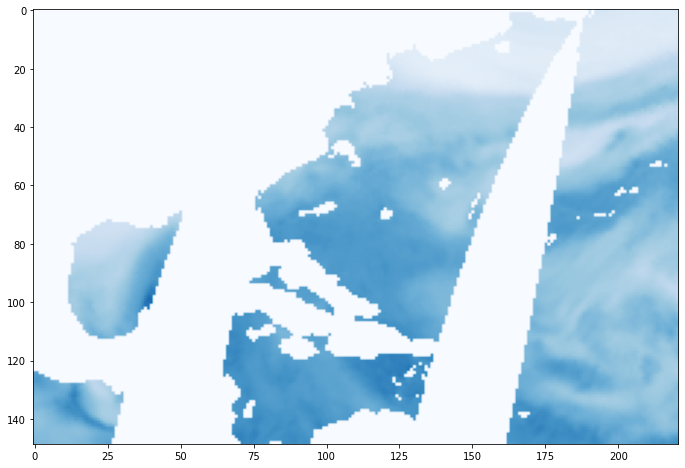

In [4]:
%%time
from aszarr import Store
import zarr

f = zarr.open(Store(url_root + 'f16_ssmis_20051022v7.nc'))
aoi_data = f['atmosphere_water_vapor_content'][rss_aoi]
show(np.where(aoi_data < RSS_NODATA, aoi_data * RSS_SCALE_FACTOR, 0), transpose=False)

## Problem 2: Rain along the East Coast on Patrick's wedding day

With the same bounding box above, get half-hourly high-quality precipitation values from GPM and sum them for the entire day (48 L3 global data files)

### Without Partial Access

Download approximately 500MB of data in whole files and processes them

 [████████████████████████████████████████████████████████████] 48/48 [03:29<00:04, 4.35s/it]

CPU times: user 9.16 s, sys: 1.36 s, total: 10.5 s
Wall time: 3min 28s


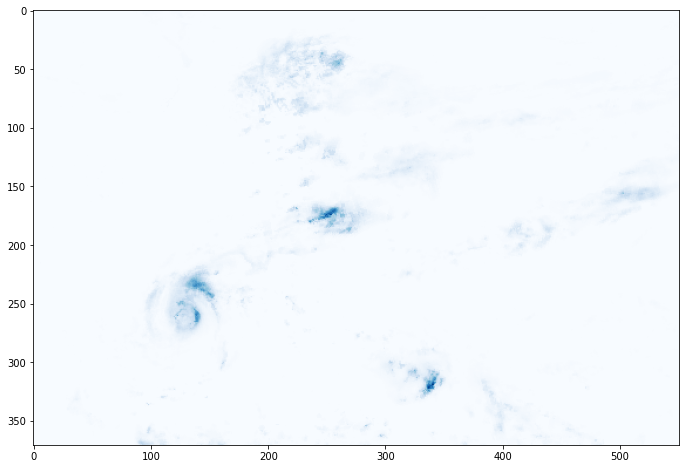

In [5]:
%%time
from h5py import File as H5File
import requests
from io import BytesIO

result = np.zeros(gpm_shape)
for url in track(data_urls):
    response = requests.get(url)
    with H5File(BytesIO(response.content), 'r') as f:
        aoi_data = f['Grid/HQprecipitation'][gpm_aoi]
        result = result + np.where(aoi_data != GPM_NODATA, aoi_data / 2, 0)
show(result)

### With the EOSDIS Zarr Store

Downloads approximately 5 MB of data by doing partial reads in fewer lines of code

 [████████████████████████████████████████████████████████████] 48/48 [03:03<00:04, 3.82s/it]

CPU times: user 2.2 s, sys: 127 ms, total: 2.33 s
Wall time: 3min 3s


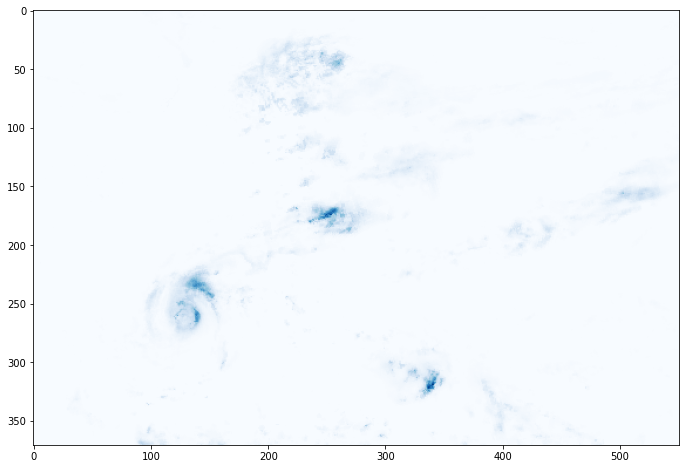

In [7]:
%%time
from aszarr import Store
import zarr

result = np.zeros(gpm_shape)
for url in track(data_urls):
    f = zarr.open(Store(url, quiet=True))
    aoi_data = f['Grid/HQprecipitation'][gpm_aoi]
    result = result + np.where(aoi_data != GPM_NODATA, aoi_data / 2, 0)
show(result)

### Comparison to L3 Daily Average Product

Download a 30 MB file from the daily average collection to produce a similar result, validating the result at 6x egress cost of partial access for all of the half-hourly source files.

In [ ]:
%%time
from h5py import File as H5File
import requests
from io import BytesIO

response = requests.get(url_root + '3B-DAY.MS.MRG.3IMERG.20051022-S000000-E235959.V06.nc4')
with H5File(BytesIO(response.content), 'r') as f:
    show(f['HQprecipitation'][gpm_aoi])

## I can see my house from here!

Download GEDI L2B data.  Use small geolocation arrays to find the area of interest, then download only the data within those chunks.  

A full file download is 1.3 GB.  The code below downloads approximately 15 MB of data and metadata.  This reduces a 15 minute download to about 8s.  (Aside: the download is 2/3 metadata, which could be dramatically reduced by using Zarr's default format rather than DMR++)

In [ ]:
from eosdis_zarr_store import Store
import zarr
import numpy as np

url = 'http://localhost:4000/data/GEDI02_B_2019182140038_O03117_T05635_02_001_01.h5'
f = zarr.open(Store(url))
print(f.tree())

In [ ]:
n, w, s, e = [40.2, -75.25, 40.15, -75.2]

geoloc = f['BEAM0000/geolocation']
all_lats = geoloc['latitude_bin0'][:]
all_lons = geoloc['longitude_bin0'][:]
valid_lat_i = np.where(np.logical_and(all_lats >= s, all_lats <= n))
valid_lon_i = np.where(np.logical_and(all_lons >= w, all_lons <= e))
indices = np.intersect1d(valid_lat_i, valid_lon_i)

lats = all_lats[indices]
lons = all_lons[indices]
data = f['BEAM0000/cover'][:][indices]
data_i = np.where(data != -9999)
data = data[data_i]
lats = lats[data_i]
lons = lons[data_i]

ambler = plt.imread('ambler.png')
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(lons, lats, s=50, c=data, cmap='Greens')
ax.set_xlim(w, e)
ax.set_ylim(s, n)
ax.imshow(ambler, zorder=0, extent = [w, e, s, n], aspect='equal')

## Why is it sometimes slower?

![png](request-overhead.png)

We pay a penalty for every new file we access, needing to go over the Internet, through the Internet services stack, the request signing process, and ultimately get redirected to S3.  The Zarr store has to pay this penalty twice to read the metadata and then the file, while a full-file download only pays the penalty once.  With current performance, the break-even point in file size is about 10 MB.  That is to say, if a user wants to access even a tiny amount of data in each granule from a collection whose granules are under 10 MB in size, he or she is better off downloading the granules.  While there is some uncontrollable overhead, there is significant room for improvement in areas that are under our control to promote inexpensive access patterns while improving time to science.

## Conclusions

* If providers generate DMR++ on ingest, we can expose our data efficiently using a Python API that is gaining increasing traction, particulary in the Pangeo community, with minimal storage overhead
* Works out of the cloud, but works even better / faster in the cloud for analysis near data
* For partial access cases, an overall egress reduction of 90% or more could be possible, as demonstrated
* Chunking matters.  This work makes smaller chunks more desirable, which has not historically been the case with Zarr
* Overhead in our stack, from EDL, to Internet services, to redirects, are eating up the potential user savings.  At a 90% egress reduction, we struggle to compete with "Just download everything."  How do we balance preventing undesirable behavior with encouraging desirable behavior?
* There are lingering questions about whether DMR++ is the correct format to capture this metadata in.  Zarr's native format is in many cases more complete and easier to parse while having mechanisms for more easily working with the 100,000-ish chunks in GEDI granules and for unifying multiple granules into a coherent view.

## Limitations / Needs

* The DMR++ file must be generated on ingest into the cloud, which is currently optional
* Only works on HDF5 and NetCDF4 files.  In principle, it could work on HDF4 / NetCDF Classic files but nothing yet generates the necessary metadata
* DMR++ does not quite specify everything we could need for some datasets.  We assume little endian byte order and column-major ordering.

## Future Work

* Packaging, unit tests, and docs sufficient for publication
* Open source (relies on a naming decision)
* Cache repeated calls for the same byte ranges to avoid requerying data we have
* Implement unknown / undocumented areas of the DMR++ spec, including compression types and data filters
* Tests with Dask and XArray
* Implement CF conventions to populate fill values, offsets, scales, etc
* Extensions to present L3 global collections as a coherent data cube

I strongly believe in this access pattern as a win for our users and ourselves.  To the extent it is not fully realized, it suffers from being an early adopter of our cloud access stack.  My sincere hope is that we can learn from it to improve partial file access not only here but in other tools and libraries.